# Markov Chain Monte Carlo for Classical Ising Model

Author: Haimeng Zhao

Email: haimengzhao@icloud.com

In this notebook, we utilize Markov Chain Monte Carlo (MCMC) method to solve the classical 2D Ising model.

Specifically, the model we are interested in is a classical ising model on a $L \times L$ square lattice with periodic boundary condition in both directions.

The Hamiltonian is as follows:
$$
H = -J\sum_{\langle i, j \rangle}\sigma_i \sigma_j + B\sum_i \sigma_i,
$$
where $\sigma_i\in\{1, -1\}$ and we set $J=1, B=0$.

# State Initialization

To implement MCMC, we first initiate the state to be a random state.

In [1]:
import numpy as np
np.random.seed(42)

def get_init_state(L):
    """
    Returns the initial state of the system and site number N = L * L
    """
    return np.random.choice([-1, 1], size=(L, L)), L * L

# Energy Difference

Next, we need the energy difference of a given random move.

In [2]:
def energy_diff(state, site):
    """
    Returns the energy increase if the spin at the given site is flipped
    """
    L = len(state)
    energy = 0
    # Add up the nearest neighbours
    for shift in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
        i, j = (site[0] + shift[0]) % L, (site[1] + shift[1]) % L
        energy += state[i, j] * state[site] * 2
    return energy

# MCMC

Now we implement the iteration process of MCMC.

In [3]:
def MCMC_iter(state, T):
    """
    Returns a new state sampled from the Metropolis algorithm
    """
    L = len(state)
    site = (np.random.randint(L), np.random.randint(L))
    delta_E = energy_diff(state, site)
    if delta_E <= 0 or np.random.random() < np.exp(-delta_E / T):
        state[site] *= -1
    return state

# Observable

To extract information from the state, we need to calculate observables.

Two basic observables are the energy $E$ and magnetization $M$.

Thanks to the fluctuation-dissipation theorem, we can obtain the specific heat $C$ and susceptibility $\chi$ easily by
$$
C = \frac{1}{T^2}\left(\langle E^2 \rangle - \langle E \rangle^2\right)\\
\chi = \frac{1}{T}\left(\langle M^2 \rangle - \langle M \rangle^2\right).
$$
Thus we only need to implement $E$ and $M$.

In [4]:
def energy(state):
    """
    Returns the total energy of the system
    """
    L = len(state)
    energy = 0
    for i in range(L):
        for j in range(L):
            energy += state[i, j] * state[(i + 1) % L, j]
            energy += state[i, j] * state[i, (j + 1) % L]
    return -energy

def magnetization(state):
    """
    Returns the total magnetization of the system
    """
    return np.sum(state)

# Demo

Now we assemble all the above parts and plot the average energy, average magnetization, specific heat, and magnetic susceptibility as functions of temperature $T$.

Furthermore, we can examine the critical exponents.

100%|██████████| 100/100 [07:48<00:00,  4.69s/it]


L = 4, n_iter 100000 MCMC done!


100%|██████████| 100/100 [10:55<00:00,  6.55s/it]


L = 6, n_iter 100000 MCMC done!


100%|██████████| 100/100 [20:29<00:00, 12.29s/it]


L = 8, n_iter 100000 MCMC done!


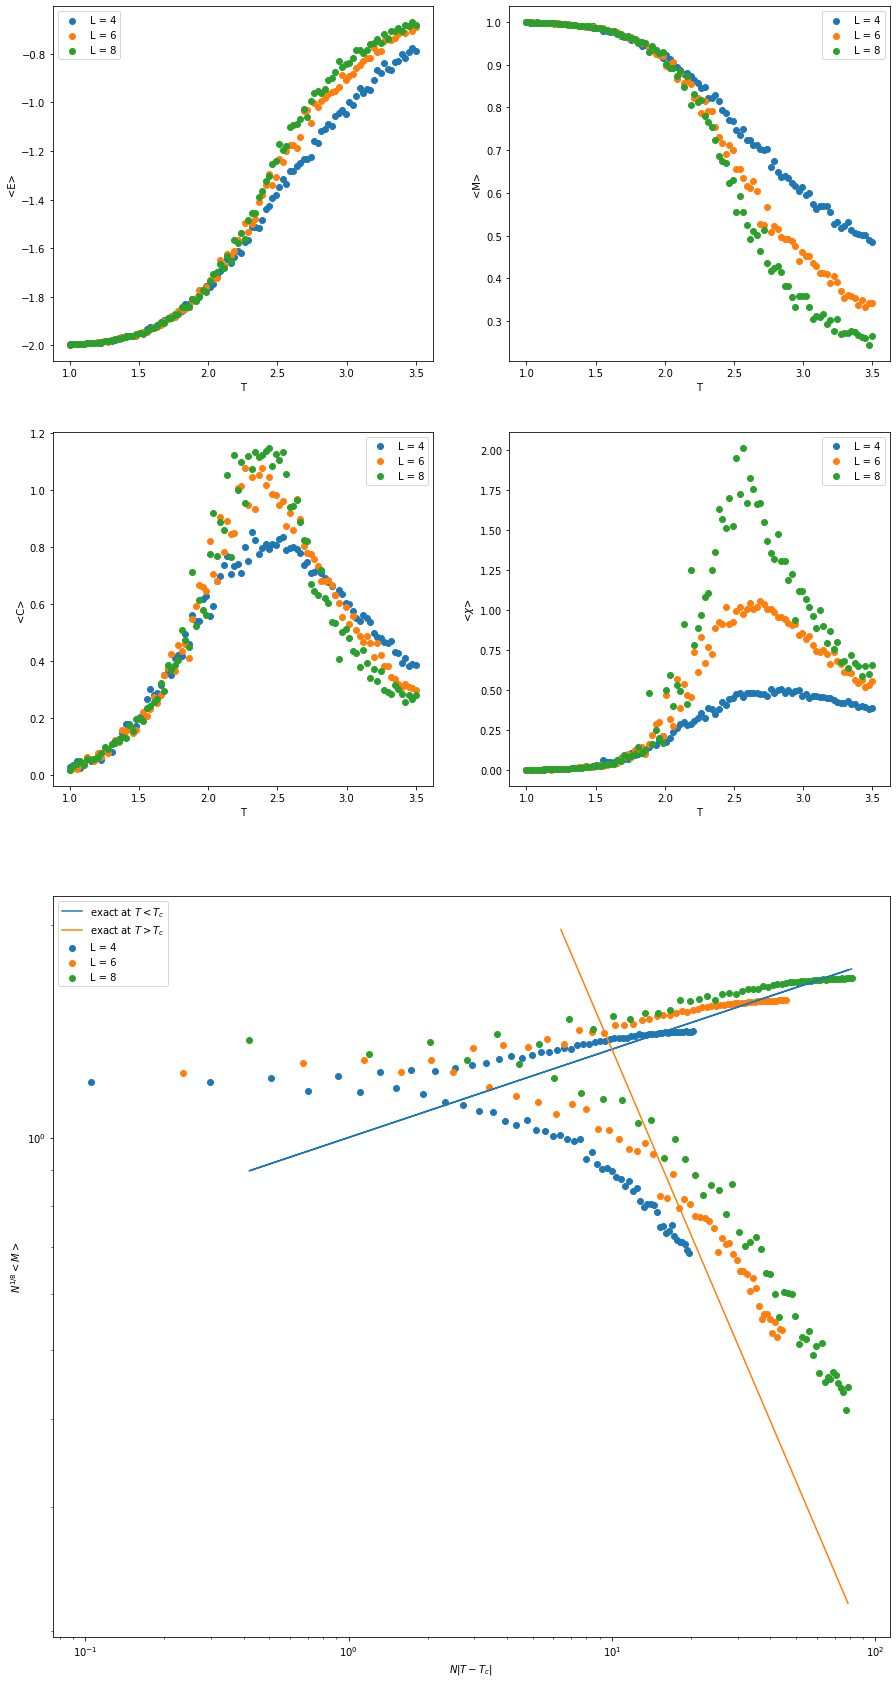

In [21]:
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

def MCMC(L, T, n_iter, n_avg=10000):
    """
    Returns the final state of the system after n_iter MCMC steps, and calculates observables
    """
    state, N = get_init_state(L)

    for _ in range(n_iter):
        state = MCMC_iter(state, T)

    energies = []
    magnetizations = []
    for _ in range(n_avg*10):
        state = MCMC_iter(state, T)
        sample_energy = energy(state)
        sample_magnetization = magnetization(state)
        energies.append(sample_energy)
        magnetizations.append(sample_magnetization)
        
    subsample_energies = np.random.choice(energies, size=n_avg)
    subsample_magnetizations = np.abs(np.random.choice(magnetizations, size=n_avg))
    avg_energy = np.mean(subsample_energies) / N
    avg_magnetization = np.mean(subsample_magnetizations) / N
    specific_heat = np.var(subsample_energies) / (T ** 2)
    susceptibility = np.var(subsample_magnetizations) / T

    return state, N, avg_energy, avg_magnetization, specific_heat, susceptibility

n_iter = 100000
L_list = [4, 6, 8]
T_list = np.linspace(1, 3.5, 100)
Tc = 2/np.log(1 + np.sqrt(2))

# initialize the figure
fig = plt.figure(figsize=(15, 30))
ax_energy = fig.add_subplot(421)
ax_energy.set_xlabel('T')
ax_energy.set_ylabel('<E>')
ax_magnetization = fig.add_subplot(422)
ax_magnetization.set_xlabel('T')
ax_magnetization.set_ylabel('<M>')
ax_specific_heat = fig.add_subplot(423)
ax_specific_heat.set_xlabel('T')
ax_specific_heat.set_ylabel('<C>')
ax_susceptibility = fig.add_subplot(424)
ax_susceptibility.set_xlabel('T')
ax_susceptibility.set_ylabel(r'<$\chi$>')
ax_exponent = fig.add_subplot(212)
ax_exponent.set_xlabel(r'$N|T-T_c|$')
ax_exponent.set_ylabel(r'$N^{1/8}<M>$')
ax_exponent.set_xscale('log')
ax_exponent.set_yscale('log')

# MCMC
for L in L_list:
    avg_energies=[]
    avg_magnetizations=[]
    specific_heats=[]
    susceptibilities=[]
    for T in tqdm(T_list):
        state, N, avg_energy, avg_magnetization, specific_heat, susceptibility = MCMC(L, T, n_iter)
        avg_energies.append(avg_energy)
        avg_magnetizations.append(avg_magnetization)
        specific_heats.append(specific_heat)
        susceptibilities.append(susceptibility)

    print(f'L = {L}, n_iter {n_iter} MCMC done!')
    # plot
    ax_energy.scatter(T_list, avg_energies, label=f'L = {L}')
    ax_magnetization.scatter(T_list, avg_magnetizations, label=f'L = {L}')
    ax_specific_heat.scatter(T_list, np.array(specific_heats)/N, label=f'L = {L}')
    ax_susceptibility.scatter(T_list, np.array(susceptibilities)/N, label=f'L = {L}')
    ax_exponent.scatter(np.abs(T_list-Tc) * N, np.array(avg_magnetizations) * (N ** (1/8)), label=f'L = {L}')
    
# exact solution
ax_exponent.plot(np.abs(T_list-Tc) * N, (np.abs(T_list-Tc) * N) ** (1/8), label=r'exact at $T<T_c$')
ax_exponent.plot(np.linspace(0.1, 3.5-Tc) * N, 10*(np.linspace(0.1, 3.5-Tc) * N) ** (-7/8), label=r'exact at $T>T_c$')
ax_energy.legend()
ax_magnetization.legend()
ax_specific_heat.legend()
ax_susceptibility.legend()
ax_exponent.legend()
plt.show()